In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch

import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as dsets

from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
import os
import numpy as np

## Resizing images

#### This part has been implemented but if you have to resize the images again uncomment and store in a separate location

In [2]:
sz = (300,300) #specify the final size

In [14]:
fn1 = !ls data/normal
fn2 = !ls data/condition

In [3]:
# for n in fn1:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/normal/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/normal/{n}',format='png')
    

In [4]:
# for n in fn2:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/condition/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/condition/{n}',format='png')

---

## Data Loaders

In [77]:
# Hyper Parameters
num_epochs = 5
batch_size = 16
learning_rate = 0.001

**This method of data loader is used if we have 2 folders train and validation and there are separate folders for each class within them**

In [105]:
# Data loading code
transform = transforms.Compose([
    transforms.RandomSizedCrop(290),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
# #     transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
# #                          std = [ 0.229, 0.224, 0.225 ]),
])

In [85]:
#for training
traindir = os.path.join('data/montgomery_china_resized/', 'train')
train = dsets.ImageFolder(traindir, transform)
train_loader = torch.utils.data.DataLoader(
train, batch_size=batch_size, shuffle=True)

In [86]:
#for test
valdir = os.path.join('data/montgomery_china_resized/', 'valid')
valid = dsets.ImageFolder(valdir, transform)
valid_loader = torch.utils.data.DataLoader(
valid, batch_size=batch_size, shuffle=False)

---

In [40]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage import io

ModuleNotFoundError: No module named 'skimage'

In [206]:
??dsets.ImageFolder(valdir, transform)

In [11]:
labels = pd.read_csv('data/labels.csv')

In [12]:
labels.head()

,id,class
0,CHNCXR_0001_0.png,normal
1,CHNCXR_0002_0.png,normal
2,CHNCXR_0003_0.png,normal
3,CHNCXR_0004_0.png,normal
4,CHNCXR_0005_0.png,normal


In [14]:
len(labels)

800

In [200]:
class Dataset_frm_csv(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, label_file, root_dir, data_folder):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(f'{root_dir}{label_file}')
        self.labels['classes'] = self.labels['classes'].apply(lambda x: 0 if x=='normal' else 1)
        self.root_dir = root_dir
        self.data_folder = data_folder
#         self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
#         set_trace()
        img_name = os.path.join(self.root_dir,self.data_folder,self.labels.iloc[idx,0])
        image = plt.imread(img_name)[:,:,:3]
#         sample = {'image': image, 'y': torch.LongTensor(np.array([labels.iloc[idx,1]]))}
#         if self.transform:
#             sample = self.transform(image)
        return image,torch.LongTensor(np.array([labels.iloc[idx,1]]))


In [201]:
test = Dataset_frm_csv(label_file='nih_label_normal_condition.csv',root_dir='data/',data_folder='images_transform')

In [202]:
test[0]

(array([[[ 0.79215688,  0.79215688,  0.79215688],
         [ 0.78039217,  0.78039217,  0.78039217],
         [ 0.7647059 ,  0.7647059 ,  0.7647059 ],
         ..., 
         [ 0.01960784,  0.01960784,  0.01960784],
         [ 0.00784314,  0.00784314,  0.00784314],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.78039217,  0.78039217,  0.78039217],
         [ 0.76862746,  0.76862746,  0.76862746],
         [ 0.7647059 ,  0.7647059 ,  0.7647059 ],
         ..., 
         [ 0.01960784,  0.01960784,  0.01960784],
         [ 0.00784314,  0.00784314,  0.00784314],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.76862746,  0.76862746,  0.76862746],
         [ 0.76078433,  0.76078433,  0.76078433],
         [ 0.75686276,  0.75686276,  0.75686276],
         ..., 
         [ 0.01960784,  0.01960784,  0.01960784],
         [ 0.00784314,  0.00784314,  0.00784314],
         [ 0.        ,  0.        ,  0.        ]],
 
        ..., 
        [[ 1.        ,  1.      

In [203]:
test_loader = torch.utils.data.DataLoader(
test, batch_size=16, shuffle=True)

In [204]:
??torch.utils.data.DataLoader()

In [205]:
x,y = next(iter(test_loader))

IndexError: single positional indexer is out-of-bounds

In [140]:
sample = Image.open('data/montgomery_china_combined/CHNCXR_0001_0.png')

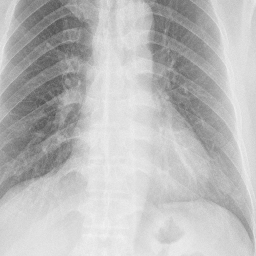

In [141]:
transform(sample)

In [144]:
transform = transforms.ToTensor()

In [145]:
transform(sample)


( 0  ,.,.) = 
  0.7686  0.8118  0.8471  ...   0.8510  0.8471  0.8471
  0.7686  0.8078  0.8392  ...   0.8588  0.8510  0.8510
  0.7647  0.8078  0.8235  ...   0.8627  0.8706  0.8549
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
[torch.FloatTensor of size 1x2919x3000]

In [5]:
# train_dataset = dsets.MNIST(root='data/',
#                             train=True, 
#                             transform=transforms.ToTensor(),
#                             download=True)

In [6]:
# test_dataset = dsets.MNIST(root='data/',
#                            train=False, 
#                            transform=transforms.ToTensor())

In [7]:
# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=False)

In [98]:

# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(72*72*32, 2)
        
    def forward(self, x):
#         set_trace()
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [99]:
cnn = CNN()
cnn.cuda()

CNN (
  (layer1): Sequential (
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc): Linear (165888 -> 2)
)

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [101]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
#         set_trace()
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

NameError: name 'train_dataset' is not defined

In [97]:
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in valid_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')

Test Accuracy of the model on the 10000 test images: 64 %
